---
---
# Introducción al aprendizaje supervisado: regresión

En este primer apartado, veremos unas cuántas cuestiones relativas a los problemas predictivos de regresión, y conoceremos los principales algoritmos que podemos aplicar en este sentido y sus propiedades.



En términos generales, un problema de aprendizaje supervisado se dice que es de **regresión** cuando la variable respuesta es continua; i.e., toma un número infinito de valores. Consideremos el siguiente ejemplo:


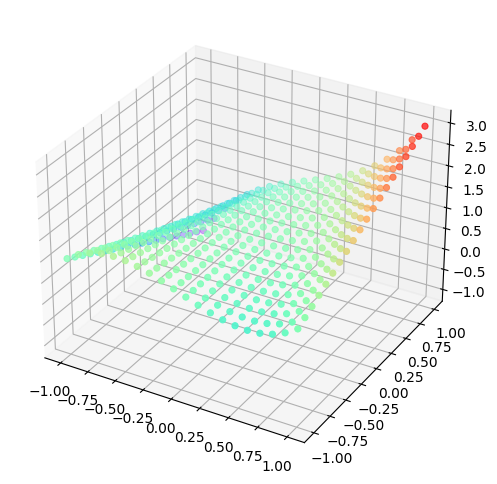

In [33]:
import numpy as np
import matplotlib.pyplot as plt
x=np.linspace(-1,1,20)
y=np.linspace(-1,1,20)
X,Y=np.meshgrid(x,y)
Z=1+X*Y+X**3
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')
ax.scatter3D(X.flatten(),Y.flatten(),Z,c=Z,cmap='rainbow',linewidth=0.7)

In [34]:
import plotly.express as px

px.scatter_3d(x=X.flatten(),y=Y.flatten(),z=Z.flatten(),template='plotly_dark',color=Z.flatten())

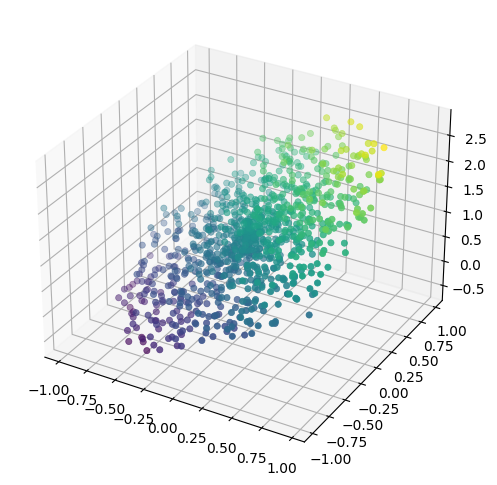

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
#Creamos datos
theta = 2 * np.pi * np.random.random(1000)
r = 1 * np.random.random(1000)
x = np.ravel(r * np.sin(theta))
y = np.ravel(r * np.cos(theta))
epsilon = .2 * np.random.randn(1000) #Añadimos algo de ruido
# epsilon=0
z = 1 + x + y + epsilon 
#Plot
fig = plt.figure(figsize = (10,6))
ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=z, cmap='viridis', linewidth=0.5)

In [36]:
px.scatter_3d(x=x, y=y, z=z,template="plotly_dark")

Es claro que los datos presentan una muy alta relación (dado por la ecuación z=1+x+y). Por métodos de mínimos cuadrados, podemos encontrar una solución analítica a este sistema de encontrar el mejor hiperplano que minimice la distancia a los puntos de *z=a+bx+cy*. Sin embargo, en el ámbito del *Machine Learning*, dichos parámetros se estudian a través de lo que se conoce como *loss function*. De forma más precisa, el algoritmo funciona como sigue:

1.   Se inicializan los parámetros asociados al problema.
2.   Se realiza el método *forward propagation*, entrenando el modelo.
3.   Se realizan las predicciones sobre el modelo entrenado. 
4.   Se comparan los valores reales con los de la predicción, mediante el uso de la *loss function*.
5.   De cara a analizar el peso de los parámetros en la justificación del error, se realiza el método de *backpropagation*, donde a partir de la regla de la cadena y analizando las derivadas parciales de la *loss function* obtenemos ponderaciones.
6.   Ajustamos los parámetros mediante el *learning rate*.

Este proceso es  conocido como *método de descenso gradiente*, y es uno de los más extendidos dentro de toda la IA. A lo largo de este proceso, hemos comentado unos cuantos conceptos que no han sido convenientemente introducidos, y que vamos a introduccir mediente un ejemplo.

Finalmente, de cara a preparar y entrenar modelos, cuando dispongamos de un cierto *dataset*, dividiremos nuestros datos en dos componentes:

*   Datos de entrenamiento.
*   Datos test.

Los últimos nos permitirán valorar y juzgar si el entrenamiento de los datos ha sido adecuado o no. Para ello, es importante tener en consideración las siguientes cuestiones, sobre las cuales profundizaremos más adelante:

*   Ratio de división.
*   Balanceamiento de datos.
*   En el caso de regresión, la distribución de la variable respuesta en ambos datos.

## Ejemplo: Regresión lineal

### Descripción

Consideraremos el caso en el que nuestra función objetivo va a depender linealmente de las variables de entrada, y donde *las incógnitas son los parámetros*:

$$h(\mathbf{\theta}) := h(\theta_0,\theta_1,\theta_2) = \theta_0+\sum_{i=1}^n\theta_i x_i$$

Equivalentemente, podemos escribir en términos matriciales:

$$h(\mathbf{\theta})  = \left(\begin{array}{cccc}1 & x_1 &  \ldots &  x_n\end{array}\right)  \left(\begin{array}{c}\theta_0 \\ \theta_1 \\\vdots \\ \theta_n\end{array}\right)  =X\mathbf{\theta}$$

Como ya indicamos, la solución *analítica* por mínimos cuadrados del problema se puede expresar como:

$$y(\mathbf{x}) := y(x_1,x_2,\ldots,x_n) = a_0+\sum_{i=1}^na_i x_i +\varepsilon = X\mathbf{A} + \varepsilon, \quad \varepsilon\sim\mathcal{N}(0,\sigma^2)$$

donde la matriz de coeficientes se calcula como:

$$\mathbf{A}=(X^tX)^{-1}(X^ty)$$

Además, dada una predicción, tomaremos como *loss function* la media cuadrática dividida entre dos (para que los gradientes queden simplificados), y como función de coste total del entrenamiento la media de las mismas:

$$J(\mathbf{\theta})=\frac{1}{2m}\sum_{i=1}^m(h(\mathbf{\theta})^{(i)}-y(\mathbf{x})^{(i)})^2$$

De cara a ponderar las fuentes del error, obtenemos el gradiente de la función *J* con respecto de sus parámetros. Concretamente, sus derivadas parciales son:

$$\frac{\partial J}{\partial \theta_j}(\mathbf{\theta})=\frac{1}{m}\sum_{i=1}^m(h(\mathbf{\theta})^{(i)}-y(\mathbf{x})^{(i)})·x_j$$

Una vez obtenida esta cantidad, actualizamos los valores de nuestros parámetros a partir del *learning rate*:

$$\theta_j\mapsto \theta_j-\alpha\frac{\partial J}{\partial \theta_j}(\mathbf{\theta})$$

En función del tamaño del parámetro *alpha*, se obtendrán unas estimaciones u otras, y por tanto el algoritmo convergerá de formas distintas, por lo que su elección y modificación durante el proceso es fundamental.

### Implementación manual

Veremos a continuación cómo implementar el proceso anterior con nuestros propios recursos, teniendo en cuenta que para operar en términos generales debemos recurrir al cálculo matricial. De hecho, implementaremos una función que haga todo este proceso de manera automática:

In [37]:
# Requerimientos
import os
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb

# Clase
class OLE_Gradient_Descent():
    def __init__(self,
                 batch_size:int = 512,
                 epochs:int = 200,
                 lr:float = 5e-3,
                 momentum:float = .1,
                 train_val_test_split:List[float] = [.5, .4, .1],
                 logging_steps:int=25,
                 early_stopping_patience:int = 3,
                 early_stopping_alpha:float = .01,
                 monitoring:bool = False,
                 dtype:str = 'float',
                 seed:int = 123,
                 ):
        # Fijamos semilla para controlar aleatoriedad
        np.random.seed(seed)

        # Validaciones
        ## Credenciales de Weights and Biases como variables de entorno
        if monitoring:
            assert (os.getenv('WANDB_USERNAME') is not None) & (os.getenv('WANDB_API_KEY') is not None), f"Please, check your Weights and Biases credentials."
        ## Fijamos y comprobamos el valor del radio de aprendizaje
        lr = np.array(lr, dtype=np.dtype(dtype))
        if np.any(lr <= 0):
            raise ValueError("'lr' must be greater than zero")
        ## Fijamos y comprobamos el valor del momentum
        momentum = np.array(momentum, dtype=np.dtype(dtype))
        if np.any(momentum <= 0):
            raise ValueError("'momentum' must be greater than zero")
        ## Fijamos y comprobamos el valor del número de iteraciones
        epochs = int(epochs)
        if epochs <= 0:
            raise ValueError("'epochs' must be greater than zero")
        ## Fijamos y comprobamos el valor de early_stopping_alpha
        early_stopping_alpha = np.array(early_stopping_alpha, dtype=np.dtype(dtype))
        if np.any(early_stopping_alpha <= 0):
            raise ValueError("'early_stopping_alpha' must be greater than zero")
        
        ## Asignación de parámetros
        self.bs = batch_size
        self.epochs = epochs
        self.lr = lr
        self.mu = momentum
        self.logging_steps = logging_steps
        self.esp = early_stopping_patience
        self.esa = early_stopping_alpha
        self.train_val_test_split = train_val_test_split
        self.monitoring = monitoring
        self.dtype_ = np.dtype(dtype)
  

    def fit(self,
            X:np.array,
            y:np.array,
            ):
        # Convertimos X e y en np.array
        X, y = np.array(X, dtype=self.dtype_), np.array(y, dtype=self.dtype_)
        if X.shape[0] != y.shape[0]:
          raise ValueError("'X' and 'y' lengths do not match")
        # Comenzamos con el algoritmo
        X = np.concatenate((np.ones((X.shape[0],1)),X), axis = 1) # Añadimos unos al principio para contemplar el parámetro theta_0
        n = X.shape[1] # Parámetros del modelo
        m = X.shape[0] # Nº de elementos de nuestros datos
        Y = y.reshape(m,1)
        data = np.concatenate((X, Y), axis=1) # Concatenamos los datos
        theta = np.random.normal(loc=0, scale=.05, size=(n)) # Inicializamos parámetros
        mse_tracker = pd.DataFrame({'train':[], 'val':[], 'test':[]})
        best_mse_val = np.inf # Inicializamos criterio parada en infinito porque la métrica es decreciente
        best_mse_patience = 0
        # Dividimos datos
        train_idx = np.random.choice(np.arange(X.shape[0]), size = int(X.shape[0]*self.train_val_test_split[0]))
        val_idx = np.random.choice([elem for elem in np.arange(X.shape[0]) if elem not in train_idx], size = int(X.shape[0]*self.train_val_test_split[1]/(self.train_val_test_split[1]+self.train_val_test_split[2])))
        test_idx = [elem for elem in np.arange(X.shape[0]) if elem not in np.concatenate((train_idx, val_idx))]
        train_data, val_data, test_data = data[train_idx,:], data[val_idx,:], data[test_idx,:]
        # Calculamos pasos de entrenamiento
        steps_per_epoch = train_data.shape[0]//self.bs+1
        total_training_steps = self.bs*steps_per_epoch
        print(f"Training data size {train_data.shape[0]}\n"\
              f"Number of steps per epoch: {steps_per_epoch}\n"\
              f"Total number of training steps: {total_training_steps}"
              )
        # Descenso gradiente
        print(f"Training model in train-val split")
        for idx in range(self.epochs):
            np.random.shuffle(data) # Operación inplace para barajar datos de entrenamiento
            # Bucle sobre datos de entrenamiento
            theta, mse_tracker = self._train_one_epoch(train_data, theta, mse_tracker, idx)
            # Bucle sobre datos de validación
            mse_tracker = self._evaluate_data(val_data, theta, mse_tracker, 'val')
            if self.monitoring:
                wandb.log({'mse_val':np.mean(mse_tracker.iloc[-1,1])}, step=(idx+1)*steps_per_epoch)
            # Comprobar la condición de parada
            if mse_tracker.iloc[-1,1]<(1-self.esa)*best_mse_val:
                best_mse_val = mse_tracker.iloc[-1,1]
                best_mse_patience = 0
            else:
                best_mse_patience += 1
            if best_mse_patience>=self.esp:
                break
        print(f"Check generalisation in test partition")
        mse_tracker = self._evaluate_data(test_data, theta, mse_tracker, 'test')
        if self.monitoring:
            wandb.log({'mse_test':np.mean(mse_tracker.iloc[-1,2])}, step=(idx+1)*steps_per_epoch)
        return theta, mse_tracker


    def _train_one_epoch(self, train_data, theta, mse_tracker, idx):
        mse_train = [] # Acumulamos mse de entrenamiento
        nabla_prev = np.zeros(theta.shape) # Inicializamos gradiente del momentum
        steps_per_epoch = train_data.shape[0]//self.bs+1
        # Bucle de entrenamiento
        for step, batch in enumerate(np.array_split(train_data, train_data.shape[0]//self.bs+1), start=1):
            X, Y = batch[:,:-1], batch[:,-1].reshape(-1,1)
            h = np.dot(X,theta.reshape(-1,1)) # Valores dependientes de los parámetros
            nabla = 1/batch.shape[0]*np.dot(X.transpose(),h-Y).flatten() # Calculamos gradiente
            nabla /= np.sqrt(np.sum(nabla**2)) # Normalizamos gradiente
            theta = theta - self.lr*nabla + self.mu*(self.lr*nabla_prev) # Actualizamos valores con el gradiente
            nabla_prev = nabla # Guardamos gradiente para próxima iteración
            mse_train.append(np.sqrt(1/X.shape[0]*np.sum((h-Y)**2)))
            if self.monitoring:
                if (step%self.logging_steps==0) | (step==steps_per_epoch):
                    wandb.log({'mse_train':np.mean(mse_train), 'learning_rate':self.lr}, step=idx*steps_per_epoch+step)
        mse_tracker = pd.concat([mse_tracker, pd.DataFrame({'train':np.mean(mse_train), 'val':np.NaN, 'test':np.NaN}, index=[idx])], axis=0)
        return theta, mse_tracker


    def _evaluate_data(self, val_data, theta, mse_tracker, flag):
        assert flag in ['val', 'test'], f"Data can only be validates in either 'val' or 'test' partitions."
        preds = [] # Lista para acumular predicciones
        # Bucle para acumular predicciones
        for batch in np.array_split(val_data, val_data.shape[0]//self.bs+1):
            X, Y = batch[:,:-1], batch[:,-1].reshape(-1,1)
            preds.append(np.dot(X,theta.reshape(-1,1)).flatten())
        # Calculamos las métricas sobre todas las predicciones
        preds = np.concatenate(preds)
        mse_tracker.iloc[-1,1 if flag=='val' else 2] = np.sqrt(1/val_data.shape[0]*np.sum((preds-val_data[:,-1].reshape(-1))**2))
        return mse_tracker

Resumimos todo el proceso:

Training data size 2500
Number of steps per epoch: 20
Total number of training steps: 2560
Training model in train-val split
Check generalisation in test partition
La mejor aproximación lineal encontrada es z = 1.00 + 0.98·x + 0.98·y


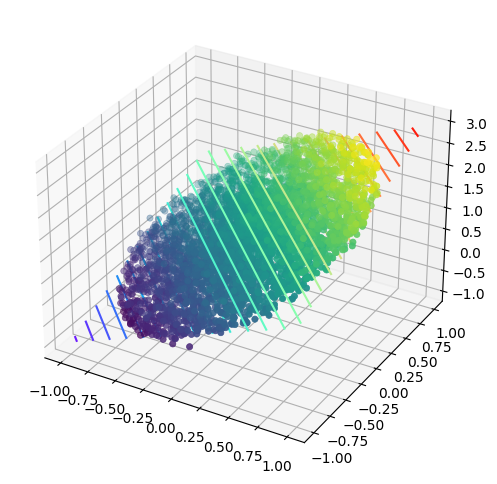

In [38]:
#Crear datos
size = 5000
theta = 2 * np.pi * np.random.random(size)
r = 1 * np.random.random(size)
x1 = np.ravel(r * np.sin(theta)).reshape(-1,1)
x2 = np.ravel(r * np.cos(theta)).reshape(-1,1)
X_model = np.concatenate((x1,x2), axis = 1)
epsilon = .1 * np.random.randn(size).reshape(-1,1) #Añadimos algo de ruido
z = 1 + x1 + x2 + epsilon
# Configuración
config={
    "batch_size":128,
    "epochs":300,
    "lr":5e-4,
    "momentum":.1,
    "logging_steps":5,
    "early_stopping_patience":3,
    "early_stopping_alpha":0.01,
    "monitoring":False,
    "seed":123,
}
# Entrenamos
linear_model = OLE_Gradient_Descent(**config)
theta, history = linear_model.fit(X_model, z)
#Obtenemos el resultado
print('La mejor aproximación lineal encontrada es z = {theta_0:.2f} + {theta_1:.2f}·x + {theta_2:.2f}·y'.format(theta_0=theta[0], theta_1=theta[1], theta_2=theta[2]))

#Dibujamos hiperplano aproximación
def f(x, y):
    return theta[0]+theta[1]*x+theta[2]*y

X1 = np.linspace(-1, 1, 1000)
X2 = np.linspace(-1, 1, 1000)
X1, X2 = np.meshgrid(X1, X2)
z = 1+x1+x2+epsilon
Z = f(X1, X2)

fig = plt.figure(figsize = (10,6))
ax = plt.axes(projection='3d')
ax.scatter(x1, x2, z, c=z, cmap='viridis', linewidth=0.5)
ax.contour3D(X1,X2,Z, 30, cmap='rainbow')

## Preparativos: *Bias-Variance tradeoff*

Como ya vimos en el apartado de clasificación, una parte de los datos es reservada para validar la efectividad del modelo. En este caso, la clase anterior ya viene convenientemente equipada para retornarnos una traza del rendimiento del algoritmo:

[]

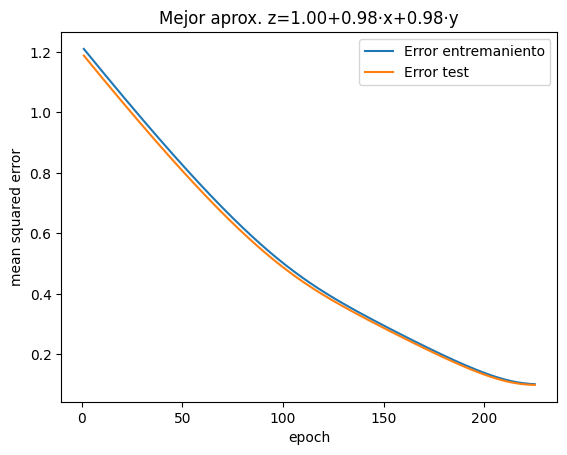

In [39]:
# Dibujamos errores entrenamiento y test
plt.plot(np.arange(1,len(history)+1), history['train'], label = "Error entremaniento")
plt.plot(np.arange(1,len(history)+1), history['val'], label = "Error test")
plt.xlabel('epoch')
plt.ylabel('mean squared error')
plt.title('Mejor aprox. z={theta_0:.2f}+{theta_1:.2f}·x+{theta_2:.2f}·y'.format(theta_0=theta[0], theta_1=theta[1], theta_2=theta[2]))
plt.legend()
plt.plot()

Observamos que el error cometido en los datos de entrenamiento y datos test es bastante parejo, lo cual indica dos cosas: la ausencia de *outliers* en los datos test, y que el modelo responde a la complejidad de los datos adecuadamente.

Para ir un paso más allá en nuestro análisis, si analizamos detenidamente la métrica *mean squared error* que utilizamos previamente como función pérdida, vemos que se puede escribir como sigue:

$$\mathbb{E}\left[(h(\mathbf{\theta})-y)^2\right]=\left(\mathbb{E}[h(\mathbf{\theta})-y]\right)^2+\mathbb{E}\left[(h(\mathbf{\theta})-\mathbb{E}[h(\mathbf{\theta})])^2\right] + \sigma_{\varepsilon}^2$$

El primero de estos dos términos es la desviación de los valores de la estimación respecto de su media; es decir, el **bias** al cuadrado. El segundo es la **varianza** del estimador, y el tercero corresponde a un error irreducible que se desprende de la propia naturaleza del modelo. Con el siguiente cuadro podemos entender la relación que existe entre las mismas:

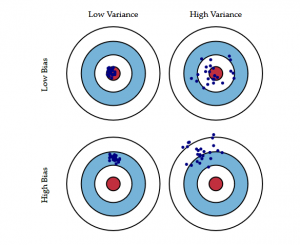

Tanto la complejidad del modelo que usemos, como el tipo de datos de entrenamiento o la elección de los parámetros del modelo son algunas de las condiciones que afectan a la interacción de ambas variables. Reconocemos ahora algunas de las principales patologías de los modelos:

*   Si la diferencia entre el error cometido en los datos de entrenamiento y test es muy grande, o equivalentemente un modelo con un *bias* muy reducido y gran varianza, se está produciendo lo que se conoce como *overfitting*, y consiste en que el modelo está demasiado optimizado para los datos de entrenamiento y es poco robusto frente a valores atípicos.
*   Si ambos errores son muy altos, o bien si el *bias* del modelo es muy grande, se produce el fenómeno de *underfitting*, que consiste en que nuestro modelo no es capaz de capturar la complejidad de los datos, y por tanto debemos de escoger un modelo o estrategia más adecuados.

En lo relativo al primer problema, la solución pasa por lo que se conocen como **técnicas de regularización**, entre las que figuran el *bagging*, *boosting* y *stacking*, que veremos más adelante.

Para estudiar estos últimos parámetros de un modelo, podemos describirlos como:

$$\text{Var}(\mathbf{\theta})=\sigma^2(X^tX)^{-1},\,\text{Bias}(\mathbf{\theta})=\mathbb{E}[\mathbf{\theta}]-A$$

donde el parámetro $\sigma$ se estima por:

$$\hat{\sigma}^2=\frac{(y-h)^t(y-h)}{m-n}$$

---
---
# Algoritmos

A continuación exponemos algunos de los algoritmos más populares en este área, y los iremos probando con el *dataset* introducido anteriormente:

In [40]:
#Creamos datos
theta = 2 * np.pi * np.random.random(1000)
r = 1 * np.random.random(1000)
x1 = np.ravel(r * np.sin(theta))
x2 = np.ravel(r * np.cos(theta))
X = np.concatenate((x1.reshape(-1,1),x2.reshape(-1,1)), axis = 1)
epsilon = .25 * np.random.randn(1000) #Añadimos algo de ruido
y = 1 + x1 + x2 + epsilon
#Dividimos datos
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .5)

## Modelos lineales

### ElasticNet

Este modelo es una generalización de otros dos, conocidos como *Ridge* y *Lasso*. La finalidad de ambos es la misma, y consiste en aplicar una **regularización** de los parámetros de estimación. En el caso anterior, estudiamos cuando la función de pérdida era del estilo:

$$\text{Features: }X\in\mathbb{R}^{n\times m},\quad \text{Label: }y\in\mathbb{R}^{n\times 1},\quad\text{Parameters: }\mathbf{\theta}\in\mathbb{R}^{m\times 1},\quad \text{Loss function: } J(\mathbf{\theta})=||X\theta-y||^2$$

Ahora, a la función de pérdida le añadimos unas variables que dependan de los parámetros:

$$\text{Features: }X\in\mathbb{R}^{n\times m},\quad \text{Label: }y\in\mathbb{R}^{n\times 1},\quad\text{Parameters: }\mathbf{\theta}\in\mathbb{R}^{m\times 1},\quad \text{Loss function: } J(\mathbf{\theta})=||X\theta-y||^2+\lambda_1||\mathbf{\theta}||_1+\lambda_2||\mathbf{\theta}||_2$$

En términos generales, la regularización con la norma suma favorece la adaptabilidad del modelo a *outliers*, mientras que la norma euclídea dota del carácter estrictamente convexo a la función pérdida, lo que garantiza la existencia de mínimos únicos. La variación de los parámetros *lambda* es lo que nos ofrece una función de pérdida u otra. En particular,

*   Cuando *lambda_1*=0, tenemos el modelo *Ridge*.
*   Cuando *lambda_2*=0, tenemos el modelo *Lasso*.

Su implementación se realiza como sigue:

In [41]:
#Librerías
from sklearn.linear_model import ElasticNet
#Inicializamos modelo y parámetros
alpha = .1 #Parámetro que mide el peso que tienen los regularizadores frente a la función original
l1_ratio = .1 #Parámetro que mide el tradeoff entre el peso l1 y el l2
#Instanciamos el modelo
model = ElasticNet(alpha = alpha, l1_ratio = l1_ratio, max_iter = 100, random_state = 0)
#Entrenamos modelo y elaboramos predicciones
model.fit(X_train, y_train)
mse_ElasticNet = np.sum((y_test-model.predict(X_test))**2)/y_test.shape[0] #Error cuadrático medio
mse_ElasticNet

0.10691082424449047

### Stochastic Gradient Descent

Este modelo es un tipo particular de descenso gradiente particularmente útil cuando se manejan datos con volumetrías alteas, pues calcula estimaciones del gradiente tomando muestras de los datos de entrenamiento. También puede ser regularizado como el algoritmo anterior, formando un tipo de *Stochastic ElasticNet*. Su implementación se realiza a continuación:

In [42]:
#Librerías
from sklearn.linear_model import SGDRegressor
#Inicializamos modelo y parámetros
penalty = 'elasticnet' #Elegimos entre penalización 'l2', 'l1' o 'elasticnet'
alpha = .1 #Parámetro que mide el peso que tienen los regularizadores frente a la función original
l1_ratio = .1 #Parámetro que mide el tradeoff entre el peso l1 y el l2
#Instanciamos el modelo
model = SGDRegressor(penalty = penalty, alpha = alpha, l1_ratio = l1_ratio, max_iter = 100, random_state = 0)
#Entrenamos modelo y elaboramos predicciones
model.fit(X_train, y_train)
mse_SGDRegressor = np.sum((y_test-model.predict(X_test))**2)/y_test.shape[0]
mse_SGDRegressor

0.1118637009793288

## Support Vector Regression

Del mismo modo que en el apartado de clasificación, tenemos una alternativa adaptable a los problemas de regresión, teniendo en cuenta que podemos personalizar los mismos parámetros del mismo. Cabe resaltar, además, que este modelo **no es invariante frente a escalamiento de datos**, por lo que se recomienda escalarlos.

Además, la elección del parámetro *C* es por defecto 1, y reducirlo implicaría mayor regularización.

In [43]:
#Librerías
from sklearn import svm
#Inicializamos modelo y parámetros
C = 1 #Parámetro regularizador
kernel = 'rbf' #Núcleo transformador
#Instanciamos el modelo
model = svm.SVR(C = C, kernel = kernel)
#Entrenamos modelo y elaboramos predicciones
model.fit(X_train, y_train)
mse_SVR = np.sum((y_test-model.predict(X_test))**2)/y_test.shape[0]
mse_SVR

0.06669105264596849

## Random Forest

Este algoritmo, visitado en el apartado de clasificación, como vimos ofrece una versión adaptable a problemas de regresión, escogiendo una forma conveniente de calcular la entropía. 

In [44]:
#Librerías
from sklearn.ensemble import RandomForestRegressor
#Inicializamos modelo y parámetros
n_estimators = 200 #Estimadores del modelo
criterion = 'squared_error' #Forma de calcular el error
max_depth = None #Límite de profundidad de los árboles
min_samples_split = 2 #Criterio de parada de profundidad
verbose = 1 #Información devuelta por el método
#Instanciamos el modelo
model = RandomForestRegressor(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, verbose=verbose)
#Entrenamos modelo y elaboramos predicciones
model.fit(X_train, y_train)
mse_RF = np.sum((y_test-model.predict(X_test))**2)/y_test.shape[0]
mse_RF

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


0.08273681305264295

In [45]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
plt.figure(figsize=(100,100))
clf=DecisionTreeRegressor().fit(X_train,y_train)
plot_tree(clf,filled=True)
plt.show()

## Boosting: *Gradient Descent*

Además del *bagging*, técnica de regularización empleada para ensamblar diferentes modelos y dar más robustez a sus resultados (véase Random Forest), estudiamos que había otra forma de regularizar que era mediante el *boosting*, y a continuación expondremos el primer ejemplo de ello.

La idea detrás del boosting es generar múltiples modelos de predicción “débiles” secuencialmente, y que cada uno de estos tome los resultados del modelo anterior, para generar un modelo más “fuerte”, con mejor poder predictivo y mayor estabilidad en sus resultados.

Para conseguir un modelo más fuerte a partir de estos modelos débiles, se emplea un algoritmo de optimización que ya hemos estudiado manualmente, en este caso *Gradient Descent*.

Durante el entrenamiento, los parámetros de cada modelo débil son ajustados iterativamente tratando de encontrar el mínimo de una función objetivo:

*   Cada modelo es comparado con el anterior. Si un nuevo modelo tiene mejores resultados, entonces se toma este como base para realizar modificaciones.
*   Si, por el contrario, tiene peores resultados, se regresa al mejor modelo anterior y se modifica ese de una manera diferente.
*   Qué tan grandes son los ajustes de un modelo a otro es uno de los hiper parámetros que debe definir el usuario.
*   Este proceso se repite hasta llegar a un punto en el que la diferencia entre modelos consecutivos es insignificante, lo cual nos indica que hemos encontrado el mejor modelo posible, o cuando se llega al número de iteraciones máximas definido por el usuario.

XGBoost usa como sus modelos débiles árboles de decisión de diferentes tipos, que pueden ser usados para tareas de clasificación y de regresión, por lo que no está de más dar un repaso a los fundamentos de este tipo de modelos para sacar el mayor provecho del algoritmo.

In [46]:
#Librerías
import xgboost as xgb
#Inicializamos modelo y parámetros
params = {"booster":"gbtree", "max_depth": 2, "eta": 0.3, "objective": "reg:squarederror", "nthread":2}
num_boost_round = 10
#Convertimos los datos a formato DMatrix
train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)
#Instanciamos el modelo, entrenamos y elaboramos predicciones
model = xgb.train(params = params, dtrain = train_data, num_boost_round=num_boost_round)
mse_XGB = np.sum((y_test-model.predict(test_data))**2)/y_test.shape[0]
mse_XGB

0.07923423152886999

## Comparativa resultados

Text(0.5, 0, 'Modelo')

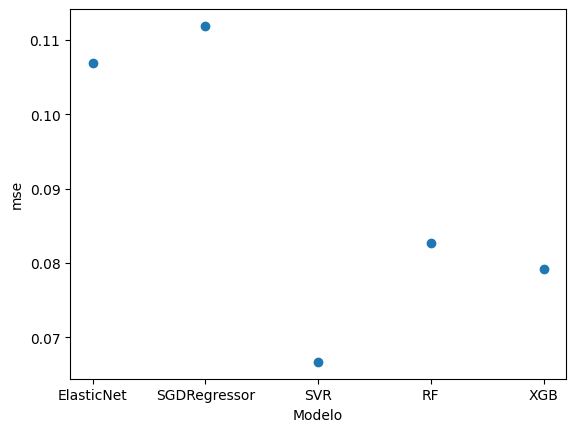

In [47]:
mse = [mse_ElasticNet, mse_SGDRegressor, mse_SVR, mse_RF, mse_XGB]
plt.scatter(['ElasticNet', 'SGDRegressor', 'SVR', 'RF', 'XGB'], mse)
plt.ylabel('mse')
plt.xlabel('Modelo')

### Ejercicios

Metro Traffic Volume per Hour
https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume


House price of a unit area
https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set


Forest Fires - Burnt Area
https://archive.ics.uci.edu/ml/datasets/Forest+Fires


Energy Efficiency - Heating and Cooling Load
https://archive.ics.uci.edu/ml/datasets/Energy+efficiency#


Computer Hardware - Estimated Relative Performance
https://archive.ics.uci.edu/ml/datasets/Computer+Hardware
